#Homework 9

In [ ]:
!rm -rf code_for_hw12* __MACOSX data .DS_Store
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw12/code_for_hw12.zip --no-check-certificate
!unzip -q code_for_hw12.zip
!mv code_for_hw12/* .
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

# 2) Decision Trees

###Decisions, decisions, decisions...
In this section, we will be looking at a dataset that aims to determine whether a wine is of good quality or bad quality based off of some features. We'll train a decision tree for our classification problem here. We first load in the data.


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

all_data = pd.read_csv("winequality-red.csv", sep=";")
all_data.loc[all_data["quality"] <= 5, "quality"] = 0
all_data.loc[all_data["quality"] > 5, "quality"] = 1

print(all_data)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0     7.4            0.700             0.00         1.90            0.076       
1     7.8            0.880             0.00         2.60            0.098       
2     7.8            0.760             0.04         2.30            0.092       
3     11.2           0.280             0.56         1.90            0.075       
4     7.4            0.700             0.00         1.90            0.076       
5     7.4            0.660             0.00         1.80            0.075       
6     7.9            0.600             0.06         1.60            0.069       
7     7.3            0.650             0.00         1.20            0.065       
8     7.8            0.580             0.02         2.00            0.073       
9     7.5            0.500             0.36         6.10            0.071       
10    6.7            0.580             0.08         1.80            0.097       
11    7.5            0.500  

In [ ]:
features = all_data.columns[:-1] # all of them except the last one (our new quality col)
print(features)
wine_data = all_data[features]
wine_labels = all_data[["quality"]]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
train_wine_data, test_wine_data, train_wine_labels, test_wine_labels =\
   train_test_split(wine_data, wine_labels, stratify = wine_labels, test_size = 0.3, random_state = 20) #do not touch random state

###Hyperparameter Search
Tuning parameters is very important when training decision trees because we run the risk of overfitting. For this reason, we'll have to use cross validation to ensure that the parameters we're setting in our decision tree not only works for our training data but validation data as well. We'll use sci-kit learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) package as our model and use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to run a parameter search to find our optimal parameters.

We can first define what parameters we want to search over, and what the values we should try are. GridSearchCV will try all possible combinations of these parameter settings and save which parameters do the best. Specifically, we will try different values for `criterion`, `min_samples_split`, `min_samples_leaf`, and `max_depth`. Please read the documentation in DecisionTreeClassifier to understand what these parameters are.


In [ ]:
#decision tree params
dt_params = {
    "criterion":["gini", "entropy"],
    "min_samples_split": [2, 5, 10, 50, 100, 150, 200, 300],
    "min_samples_leaf": [2, 5, 10, 20, 100, 150, 200, 250],
    "max_depth": [3, 5, 10, 50, 100]
}

####Conceptual Questions
1) How does increasing min_samples_split affect training accuracy? Test accuracy?

2) How does increasing min_samples_leaf affect training accuracy? Test error?

3) How does increasing max_depth affect training accuracy? Test error?


Look at the GridSearchCV documentation and DecisionTreeClassifier documentation to run a hyperparameter search on the wine dataset. Search over the space defined in `dt_params`. For the next section, due to the stochastic nature of creating training and test datasets, multiple solutions are accepted. If you believe that your method is correct but the solution isn't being accepted, please post a private message directed to staff on Piazza with your methodology and results. Due to the stochastic nature of creating training and test datasets, multiple solutions are accepted, but you should fix the parameter **random_state=10** for the DecisionTreeClassifier to ensure you get the staff output

In [ ]:
#todo, use GridSearchCV to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=10), dt_params)
gridsearch.fit(train_wine_data, train_wine_labels)
best_params = gridsearch.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50}


In [ ]:
best_params = {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50}
print(best_params)

#Now we will use all of the training data to relearn a decision classifier
decision_clf = DecisionTreeClassifier(**best_params)
decision_clf.fit(train_wine_data, train_wine_labels)
print(decision_clf.score(test_wine_data, test_wine_labels)) #find the score of the test data, metric is mean accuracy from docs

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50}
0.71875


Now, we will use sci-kit learn's [plot tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) to visualize our learned decision tree.

As an example, if our node is


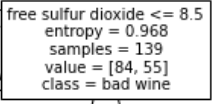

this means we are splitting along the "free sulfur dioxide" feature, there are 84 wines in this node that are classified as bad wine and 55 wines in this node that are classified as good wine. Thus, we output the label bad wine for this node.

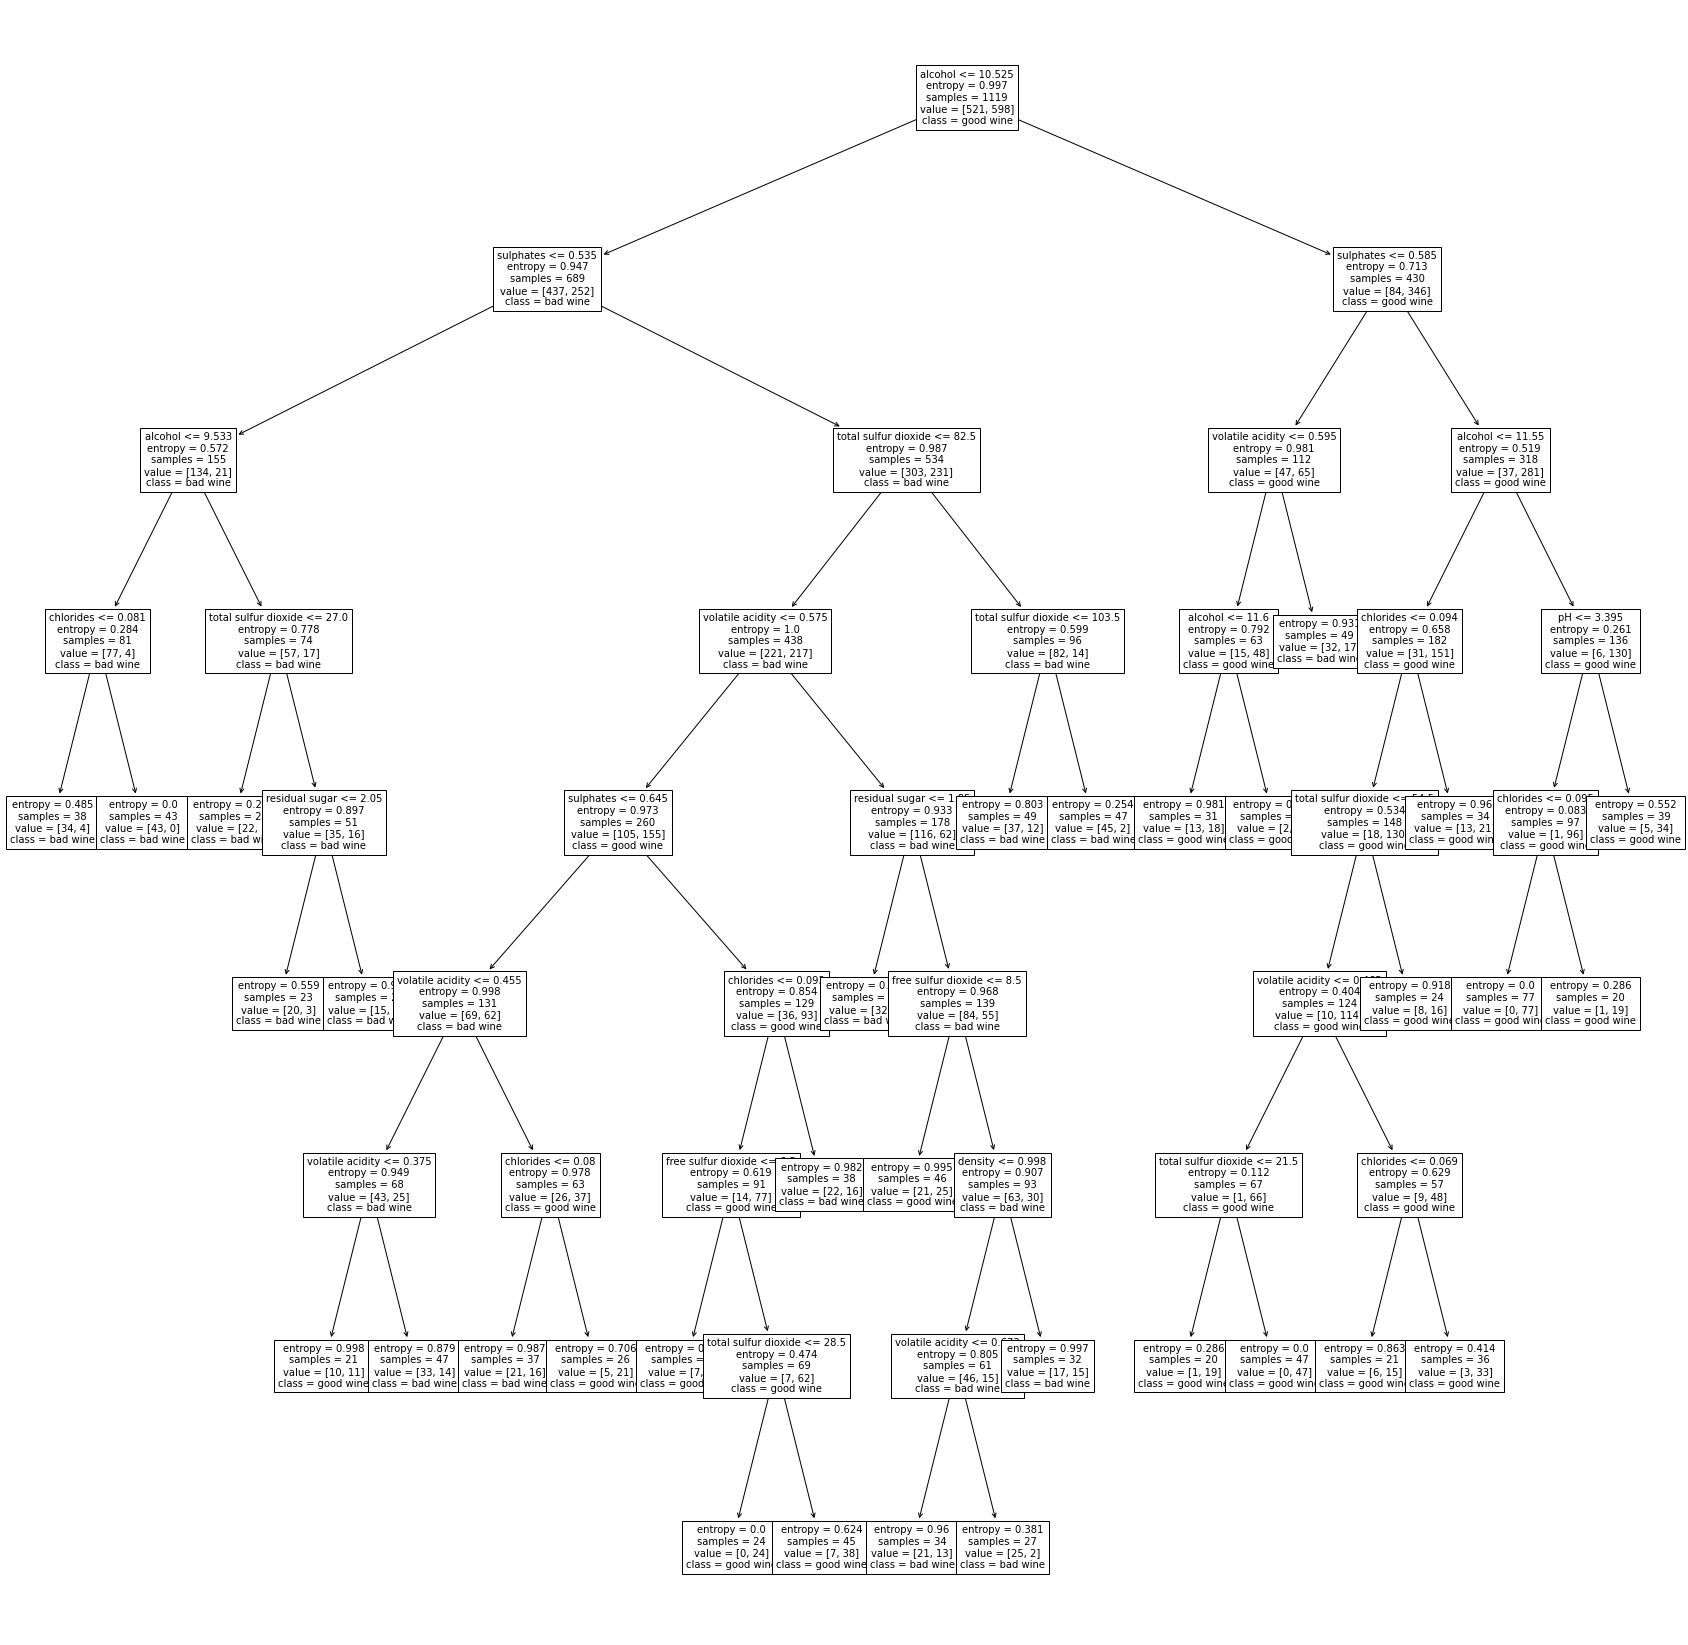

In [ ]:
# #visualize the tree
fig, ax = plt.subplots(figsize=(30, 30))
plot = plot_tree(decision_clf, feature_names = features, class_names=["bad wine", "good wine"], fontsize=10, ax=ax)

Answer the questions on catsoop about the interpretation of this tree.

###Logistic Regression Hyperparameter Search
Now, we want to compare our decision tree to a logistic regression to see if the decision tree is picking up some nonlinearities in the dataset. We do the same thing for a logistic regression: we first run a hyperparameter search for the best parameters for [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and compare the accuracies and interpretations. Please read the documentation for LogisticRegression to understand the settings in `lr_params`.

In [ ]:
lr_params = {
        "penalty":["l1", "l2"],
        "C":[1e-3, 1e-2, 1e-1, 1, 5, 10, 100, 250],
        "solver": ["liblinear"]
}

####Conceptual Questions
How does increasing $C$ affect training accuracy? Testing accuracy?

Now, run a hyperparameter search using GridSearchCV again, but for a logistic regression. Due to the stochastic nature of creating training and test datasets, multiple solutions are accepted, but you should fix the parameter **random_state=10** for the LogisticRegression to ensure you get the staff output

In [ ]:
#reshape train_wine_labels to be 1D
train_wine_labels_1d = np.array(train_wine_labels).reshape(len(train_wine_labels),)
# TODO: Use GridSearchCV to find the best parameter values for a logistic regression classifier
#hint, you might want to use train_wine_labels_1d as the input to this GridSearchCV, why?

#todo, use GridSearchCV to find the best parameters
gridsearch_logistic = GridSearchCV(LogisticRegression(random_state=10), lr_params)
gridsearch_logistic.fit(train_wine_data, train_wine_labels_1d)
best_params = gridsearch_logistic.best_params_
print(best_params)


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
lr_best_params = best_params #set this equal to the best parameters found by the logistic regression
print(lr_best_params)
lr_classifier = LogisticRegression(**lr_best_params)
lr_classifier.fit(train_wine_data, train_wine_labels_1d)
print(lr_classifier.score(test_wine_data, test_wine_labels))

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.7458333333333333


Similarly to when analyzing decision trees, we would like to determine which features play the most important role in classifying whether a wine is good or bad. Take a look at the coefficients of this model and determine which feature is the most important to classifying a good wine vs a bad wine.

In [ ]:
lr_coefficients = lr_classifier.coef_#get the coefficients of the logistic regression
# get the weights of the features of the wine data
sorted_coeff_indices = np.argsort(np.abs(lr_coefficients))
for i in sorted_coeff_indices[0]:
    print("%s: %s" %(features[i], lr_coefficients[0][i]))

total sulfur dioxide: -0.017029989956300156
free sulfur dioxide: 0.027029755054868914
residual sugar: 0.03680015599882383
fixed acidity: 0.11426425996601319
pH: -0.34519739489892476
alcohol: 0.9002596492453105
citric acid: -1.262121024913849
chlorides: -2.370079158503639
sulphates: 2.495163500574919
volatile acidity: -3.6606234284399366
density: -3.936987158541386


However, the coefficients as is don't provide much intuition on how important the features are, since the features could be of different scale. So if we have features that naturally take on very large values, they may artificially get a small coefficient. For that reason, we scale the data inputs and take a look at the coeffiecients of the scaled features.

Now, what is the most important feature?

In [ ]:
lr_classifier_scaled = LogisticRegression(**lr_best_params)
lr_classifier_scaled.fit(scale(train_wine_data), train_wine_labels_1d)
print(lr_classifier_scaled.score(scale(test_wine_data), test_wine_labels))

0.7395833333333334


In [ ]:
lr_coefficients_scaled = lr_classifier_scaled.coef_ #get the coefficients of the scaled logistic regression model
# get the weights of the scaled features of the wine data
sorted_coeff_indices = np.argsort(np.abs(lr_coefficients_scaled))
for i in sorted_coeff_indices[0]:
    print("%s: %s" %(features[i], lr_coefficients_scaled[0][i]))

density: -0.01114756407706229
pH: -0.02547002527541214
residual sugar: 0.0566302761492648
chlorides: -0.12136634980143031
fixed acidity: 0.2241585629133923
citric acid: -0.2536324342052114
free sulfur dioxide: 0.27160413667203337
sulphates: 0.4273796059691471
total sulfur dioxide: -0.5491981213324866
volatile acidity: -0.6549289774372986
alcohol: 0.9760099890688674


While we're still able to determine what features are important in classifying whether a wine is good or bad, we have no sense of what values these features need to take to classify whether a wine is good or bad, like we were able to do in a decision tree.

###Random Forest Hyperparameter Search
Finally, we do the same hyperparameter search for a random forest. Use GridSearchCV again to find the best setting of parameters from `rf_params`. Performing this search may take some time (around 5-10 minutes), so be patient! When initializing `RandomForestClassifier`, please use a **random state of 10**, to ensure that the output stays consistent with the solutions on Catsoop!




In [ ]:
rf_params = {
    "n_estimators":[50, 200],
    "criterion":["gini", "entropy"],
    "max_depth":[2, 10, 50],
    "min_samples_leaf":[2,10,50]
}

In [ ]:
#todo: run a hyperparameter search over rf_params for a random forest here
#todo, use GridSearchCV to find the best parameters
gridsearch_random_forest = GridSearchCV(RandomForestClassifier(random_state=10), rf_params)
gridsearch_random_forest.fit(train_wine_data, train_wine_labels_1d)
best_params = gridsearch_random_forest.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}


In [ ]:
rf_best_params = gridsearch_random_forest.best_params_
print(rf_best_params)
rf_clf = RandomForestClassifier(**rf_best_params, random_state = 10) #do not touch random state
rf_clf.fit(train_wine_data, train_wine_labels_1d)
print(rf_clf.score(test_wine_data, test_wine_labels))

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}
0.7916666666666666


We see that a big advantage of using sci-kit learn is its ability to quickly switch out different models we would like to use. All we need to change is the hyperparameters we want to search over and the model input to GridSearchCV!




# 4) Nearest Neighbor Implementation


Implement the following distance functions below according to their specifications. They should compute the pairwise distance between a single sample of dimension (d,1)(d,1) and nn individual samples, each with dimension (d,1)(d,1), in an array of dimension (d,n)(d,n). This will make it easy to compute the distances between a single test sample and the entire training set in KNN. Numpy is preloaded for you, but you can't use np.linalg.norm.

A) Implement the Euclidean distance below. Remember that the Euclidean distance between two dd-dimensional vectors is defined as :

$$E(p,q) = \sqrt{\sum_{i=1}^{d}(p_i - q_i)^2}$$




In [ ]:
def euclidean(p,q):
    """
    Parameters:
        p is d by n array
        q is d by 1 array
    Returns :
        (n,) (i.e. one-dimensional, n elements) array: the pairwise Euclidean distance of q with respect to individual samples in  p
    """
    return np.sqrt(np.sum((p - q)**2, axis = 0))

In [ ]:
def test_euclidean():
    passed = 0
    p = np.array([[10], [-4]])
    q = np.array([[0], [1]])
    c = np.array([11.180339887498949])
    if np.isclose(euclidean(p,q), c):
        passed += 1
    else:
        print("failed test case 1")
    p = np.array([[0, 1, 1, -4, -2], [0, 1, 2, 9, -2]])
    q = np.array([[-2], [1]])
    c = np.array([2.23606797749979, 3.0, 3.1622776601683795, 8.246211251235321, 3.0])
    if np.isclose(euclidean(p,q), c).all():
        passed += 1
    else:
        print("failed test case 2")
    print(f"passed {passed}/2 test cases")
test_euclidean()

passed 2/2 test cases


B)Implement the Manhattan distance below. Remember that the Manhattan distance between two d-dimensional vectors is defined as :

$$M(p,q) = \sum_{i=1}^{d}|p_i - q_i|$$


In [ ]:
def manhattan(p,q):
    """
    Parameters:
        p is d by n array
        q is d by 1 array
    Returns :
        (n,) (i.e. one-dimensional, n elements) array: the pairwise Manhattan distance of q with respect to individual samples in p
    """
    return np.sum(np.abs(p - q), axis = 0)

In [ ]:
def test_manhattan():
    passed = 0
    p = np.array([[10], [-4]])
    q = np.array([[0], [1]])
    c = np.array([15])
    if np.isclose(manhattan(p,q), c):
        passed += 1
    else:
        print("failed test case 1")
    p = np.array([[0, 1, 1, -4, -2], [0, 1, 2, 9, -2]])
    q = np.array([[-2], [1]])
    c = np.array([3, 3, 4, 10, 3])
    if np.isclose(manhattan(p, q), c).all():
        passed += 1
    else:
        print("failed test case 2")
    print(f"passed {passed}/2 test cases")
test_manhattan()

passed 2/2 test cases


C) Implement the KNN class for classification below according to its specifications. Some functions that may come in handy are `np.argsort` and `np.bincount`. If you need a refresher on how KNNs work for classification, take a look at [the notes](https://lms.mitx.mit.edu/assets/courseware/v1/f0cc0c187c20a52b6ca4d967efdca4f0/asset-v1:MITx+6.036+2020_Fall+type@asset+block/notes_chapter_Non-parametric_methods.pdf).

In [ ]:
class KNN:
    def __init__(self, K, distance_metric, trainX, trainY):
        """
        Parameters:
            K is an int representing the number of closest neighbors to consider
            distance_metric is one of euclidean or manhattan
            trainX is d by n array
            trainY is 1 by n array
        """
        self.trainX = trainX
        self.trainY = trainY
        self.K = K
        self.metric = distance_metric

    def calc_distances(self, testX):
        """
        Parameters:
            testX is d by m np array
        Returns:
            an m x n np array D where D[i, j] is the distance between test sample i and train sample j
        """
        dist = []
        d, m = testX.shape
        for i in range(m):
            col = testX[:,i:i+1]
            dist.append(self.metric(self.trainX, col))
        return np.array(dist)

    def find_top_neighbor_labels(self, dists):
        """
        Parameters:
            dists is  m x n np array D where D[i, j] is the distance between test sample i and train sample j
        Returns:
            an m x K np array L where L[i, j] is the label of the jth closest neighbor to test sample i
            in case of ties, the neighbor which appears first in the training set is chosen
        """
        m, n = dists.shape
        sorted_dists_indices = np.argsort(dists, axis=1)
        labels = self.trainY.reshape((n, ))[sorted_dists_indices]
        return labels[:,:self.K]

    def predict(self, testX):
        """
        Parameters:
            testX is d by m np array
        Returns:
            predicted is (m,) np array P where P[i] is the predicted label for test sample i
        """
        d, m = testX.shape
        distances = self.calc_distances(testX)
        nearest_labels = self.find_top_neighbor_labels(distances)
        counted_labels = np.array([np.argmax(np.bincount(nearest_labels[i,:])) for i in range(m)])
        return counted_labels



    def score(self, testX, testY):
        """
        Parameters:
            testX is d by m np array of input data
            testY is 1 by m np array of labels for the input data
        Returns:
            a scalar: the accuracy of the KNN predictions across the test set
        """
        return np.count_nonzero(self.predict(testX) == testY) / testY.shape[1]
        # pass
        # d, m = testX.shape
        # predicted = self.predict(testX)
        # differences = predicted - testY
        # return np.count_nonzero(differences) / m


In [ ]:
import math

trainx = np.array([[ 2., 16., 4., 3., 3., 6., 4.], [15., 15., 13., 13., 13., 12., 15.], [15., 3., 8., 13., 16., 16., 16.]])
trainy = np.array([[0,1,2,2,1,0,1]])
testx = np.array([[ 9., 15.,  0., 14., 16.], [ 9., 16.,  6., 13., 14.],[16., 15., 16., 16., 11.]])
testy_1 = np.array([[0, 1, 2, 1, 0]])
knn1 = KNN(1, euclidean, trainx, trainy)
knn1_1 = KNN(1, euclidean, testx, testy_1)
knn3 = KNN(3, euclidean, trainx, trainy)
knn5 = KNN(5, euclidean, trainx, trainy)

passed = 0
print("testing knn.calc_distances")
knn1 = KNN(1, euclidean, trainx, trainy)
dists = knn1.calc_distances(testx)
expected = np.array([[9.273618495495704, 15.937377450509228, 10.246950765959598, 7.810249675906654, 7.211102550927978, 4.242640687119285, 7.810249675906654], [13.038404810405298, 12.083045973594572, 13.379088160259652, 12.529964086141668, 12.409673645990857, 9.899494936611665, 11.090536506409418],
                     [9.273618495495704, 22.494443758403985, 11.357816691600547, 8.18535277187245, 7.615773105863909, 8.48528137423857, 9.848857801796104], [12.206555615733702, 13.30413469565007, 12.806248474865697, 11.40175425099138, 11.0, 8.06225774829855, 10.198039027185569],
                     [14.594519519326424, 8.06225774829855, 12.409673645990857, 13.19090595827292, 13.96424004376894, 11.357816691600547, 13.038404810405298]])
if np.isclose(dists, expected).all():
    passed += 1
else:
    print("failed test 1")
expected = np.array([[9.273618495495704, 13.038404810405298, 9.273618495495704, 12.206555615733702, 14.594519519326424], [15.937377450509228, 12.083045973594572, 22.494443758403985, 13.30413469565007, 8.06225774829855],
                     [10.246950765959598, 13.379088160259652, 11.357816691600547, 12.806248474865697, 12.409673645990857], [7.810249675906654, 12.529964086141668, 8.18535277187245, 11.40175425099138, 13.19090595827292],
                     [7.211102550927978, 12.409673645990857, 7.615773105863909, 11.0, 13.96424004376894], [4.242640687119285, 9.899494936611665, 8.48528137423857, 8.06225774829855, 11.357816691600547],
                     [7.810249675906654, 11.090536506409418, 9.848857801796104, 10.198039027185569, 13.038404810405298]])
dists = knn1_1.calc_distances(trainx)
if np.isclose(dists, expected).all():
    passed += 1
else:
    print("failed test 2")
print("testing knn.find_top_neighbor_labels")
expected = np.array([[0], [0], [1], [0], [1]])
dists = np.vstack([knn1.metric(knn1.trainX, testx[:, i:i+1]) for i in range(testx.shape[1])])
actual = knn1.find_top_neighbor_labels(dists)
if np.isclose(actual, expected).all():
    passed += 1
else:
    print("failed test 3")
expected = np.array([[0], [0], [0], [0], [0], [0], [0]])
dists = np.vstack([knn1_1.metric(knn1_1.trainX, trainx[:, i:i+1]) for i in range(trainx.shape[1])])
actual = knn1_1.find_top_neighbor_labels(dists)
if np.isclose(actual, expected).all():
    passed += 1
else:
    print("failed test 4")
#test case 5
expected = np.array([[0, 1, 2], [0, 1, 1], [1, 2, 0], [0, 1, 1], [1, 0, 2]])
dists = np.vstack([knn3.metric(knn3.trainX, testx[:, i:i+1]) for i in range(testx.shape[1])])
if np.isclose(knn3.find_top_neighbor_labels(dists), expected).all():
    passed += 1
else:
    print("failed test 5")
#test case 6
print("testing knn.predict")
expected = np.array([0, 0, 1, 0, 1])
print('HERE: ', knn1.predict(testx))
if np.isclose(knn1.predict(testx), expected).all():
    passed += 1
else:
    print("failed test 6")

#test case 7
expected = np.array([0, 1, 2, 1, 0])
if np.isclose(knn1_1.predict(testx), expected).all():
    passed += 1
else:
    print("failed test 7")

#test case 8
expected = np.array([0, 1, 0, 1, 0])
if np.isclose(knn3.predict(testx), expected).all():
    passed += 1
else:
    print("failed test 8")

#test case 9
expected = np.array([0, 1, 0, 0, 1])
if np.isclose(knn5.predict(testx), expected).all():
    passed += 1
else:
    print("failed test 9")

print("testing knn.score")
#test case 10
expected = 0.8
if math.isclose(knn3.score(testx, testy_1), expected):
    passed += 1
else:
    print("failed test 10")

#test case 11
expected = 0.4
if math.isclose(knn5.score(testx, testy_1), expected):
    passed += 1
else:
    print("failed test 11")
print(f"passed {passed}/11 test cases")




testing knn.calc_distances
testing knn.find_top_neighbor_labels
testing knn.predict
counted labels:  [0 0 1 0 1]
HERE:  [0 0 1 0 1]
counted labels:  [0 0 1 0 1]
counted labels:  [0 1 2 1 0]
counted labels:  [0 1 0 1 0]
counted labels:  [0 1 0 0 1]
testing knn.score
counted labels:  [0 1 0 1 0]
counted labels:  [0 1 0 0 1]
passed 11/11 test cases


# 5) NN: Nearest Neighbors or Neural Networks?


Now that we have implemented our K-Nearest Neighbors algorithm, we can test how well it does on Scikit-learn's MNIST dataset.

First, we need to process data to fit our class standards. Scikit-learn's input data take the form $(n,d)$ and labels take the form $(n,)$. Implement the function below so that the data can be fed into our KNNs (refer back to the KNN specifications above if you don't remember the needed shapes).


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

mnist = datasets.load_digits()
train_data, test_data, train_labels, test_labels = train_test_split(np.array(mnist.data), mnist.target, test_size=0.25, random_state=42)

In [ ]:
def process_data_for_knn(train_data, test_data, train_labels, test_labels):
    trainX = train_data.T
    testX = test_data.T
    trainY = train_labels.reshape((1, -1))
    testY = test_labels.reshape((1, -1))
    return trainX, testX, trainY, testY

Now we'll evaluate the KNN accuracy on various values of K using Euclidean distance and compare its performance to a simple neural network.

A) What is the accuracy of KNN using Euclidean distance on the MNIST dataset for K=1, 3, 5?


In [ ]:
trainX, testX, trainY, testY = process_data_for_knn(train_data, test_data, train_labels, test_labels)
EucNN1 = KNN(1, euclidean, trainX, trainY)
EucNN3 = KNN(3, euclidean, trainX, trainY)
EucNN5 = KNN(5, euclidean, trainX, trainY)
print(EucNN1.score(testX, testY))
print(EucNN3.score(testX, testY))
print(EucNN5.score(testX, testY))

counted labels:  [6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 3 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 9 7 2 6 9 4 0 7 2 7 5 8 7 5 7 9 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 3 9 3 4 7 2 9 0 4 5 3 6 5 9 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 5 4 2 3 6 4 8 5 9 5 7 1 9 4 8 1 5 4 4 9 6 1 8 6 0 4 5 2 7
 1 6 4 5 6 0 3 2 3 6 7 1 5 1 4 7 6 8 8 5 5 1 6 2 8 8 9 5 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 7 0 1 0 4 5 1 5 3 6 0 4 1 0 0 3 6 5 9 7 3 5 5 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 1 5 2 1 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 5 0 6 2 0 7 9 8 9 5 2 7 7 1 8 7 4 3 8 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 4 5 9 6 3 1 8 8 4 2 3 8 9 8 8 5 0 6 3 3 7 1 6 4 1 2 1 1 6 4 7 4 8 3 4
 0 5 1 9 4 5 7 6 3 7 0 5 9 7 5 9 7 4 2 1 9 0 7 5 8 3 6 3 9 6 9 5 0 1 5 5 8
 3 3 6 2 6 5]
0.9822222222222222
counted labels:  [6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 

Use the code below to test how well a simple Neural network with two hidden layers, of sizes 50 and 5, performs.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import warnings
from sklearn.exceptions import ConvergenceWarning

norm_train_data, norm_test_data = train_data/16, test_data/16
mlp = MLPClassifier(hidden_layer_sizes=(50,5), max_iter=10000, alpha=1e-4, solver='sgd', verbose=None, random_state=1,learning_rate_init=.1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(norm_train_data, train_labels)
    #TODO: your code here: score the mlp on the test data by getting the accuracy
    mlp_score = mlp.score(norm_test_data, test_labels)
    print(mlp_score)

0.9688888888888889


B) What is the accuracy of the provided Neural Network on the MNIST dataset?


C) What performs marginally better on this simple dataset: nearest neighbors or neural networks?

# 6) Nearest Neighbors for Few-Shot Learning


One of the major benefits of KNNs that we hinted at during lab 7 is that they can do surprisingly well in few-shot
learning settings, where only a few labeled examples are available. More specifically, we hypothesized that by doing KNNs on embeddings of the examples provided by an auto-encoder, we could get a great performance with ony a few single labeled examples. Let's put it to the test!


We first start by training an auto-encoder. Because we want to test the KNN, not the auto-encoder itself, we will use the entire dataset to train the auto-encoder and produce the embeddings. As always for neural nets, we standardize the data first.

In [ ]:
mnist = datasets.load_digits()
all_data, _, all_labels, _ = train_test_split(np.array(mnist.data), mnist.target, test_size=0.01, random_state=42)
all_data = all_data/16  #max int is 16

To simplify the task a little bit, we will only keep 2 classes: zeros and twos. Use the `keep_subset_classes` function below, which takes in a list of integers corresponding to the classes we want to keep, and returns that subset of the data and labels with only those classes.


In [ ]:
def keep_subset_classes(data, labels, labels_to_include):
    """
    Parameters:
        data is (n,d)
        labels is (n,)
        labels_to_include is a list of unique labels corresponding to the classes to be kept
    Returns:
        multiclass_data (m,d) where m is the number of examples belonging to the classes in labels_to_include
        multiclass_labels (m,) where m is the number of examples belonging to the classes in labels_to_include
    Note the shapes are different this time, as they use scikit-learn's convention.
    """
    multiclass_data = data[np.isin(labels, labels_to_include)]
    multiclass_labels = labels[np.isin(labels, labels_to_include)]
    return multiclass_data, multiclass_labels

In [ ]:
labels_to_include = [0, 2]
multiclass_data, multiclass_labels = keep_subset_classes(all_data, all_labels, labels_to_include)

Next, we define the architecture of an auto-encoder similar to the one we saw in lab 7 and train it on the multiclass data. Use the `MLPRegressor`'s `fit` function to train the auto-encoder. Be careful with what the input data and the output "labels" are in this case (remember that an auto-encoder tries to reconstruct the inputs)! Training will take a few minutes.

In [ ]:
n_input = 8*8
n_encoder = 128
n_latent = 2
n_decoder = 128

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

reg = MLPRegressor(hidden_layer_sizes=(n_encoder, n_latent, n_decoder), activation = 'tanh',
                   solver = 'adam', learning_rate_init = 0.0001, max_iter = 10000,
                   tol = 0.0000001, verbose = False, random_state=2)

# TODO: Fit the MLPRegressor
reg.fit(multiclass_data, multiclass_data)


MLPRegressor(activation='tanh', hidden_layer_sizes=(128, 2, 128),
             learning_rate_init=0.0001, max_iter=10000, random_state=2,
             tol=1e-07)

Now that we have trained our auto-encoder, we can retrieve the embeddings (i.e. latent space representation) and the reconstructions. While we don't need the reconstructions per se, they are useful to sanity check that our training was succesful. If you need a refresher on how auto-encoders work, have a look at lab 7.

In [ ]:
def encoder(data):
    data = np.asmatrix(data)
    encoder1 = np.tanh(data@reg.coefs_[0] + reg.intercepts_[0])
    latent = np.tanh(encoder1@reg.coefs_[1] + reg.intercepts_[1])
    return np.asarray(latent)

def decoder(new_data):
    new_data = np.asmatrix(new_data)
    decoder1 = np.tanh(new_data@reg.coefs_[2] + reg.intercepts_[2])
    reconst = decoder1@reg.coefs_[3] + reg.intercepts_[3]
    return np.asarray(reconst)

multiclass_latent = encoder(multiclass_data)
multiclass_reconstruct = decoder(multiclass_latent)

We can visualize the reconstructions and originals below to ensure the auto-encoder has learned relevant embeddings.

RECONSTRUCTION


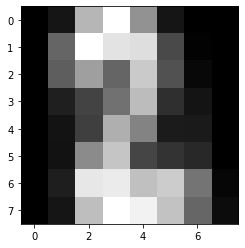

ORIGINAL


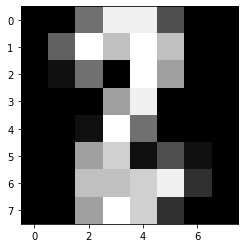

In [ ]:
import matplotlib.pyplot as plt

def visualize(pixels):
    pixels = pixels.reshape((8,8))
    plt.imshow(pixels, cmap='gray')
    plt.show()

print('RECONSTRUCTION')
visualize(multiclass_reconstruct[30, :]) #our reconstruction
print('ORIGINAL')
visualize(multiclass_data[30, :]) #the original

The code below is already implemented for you. The two dictionaries `lab2im` and `lab2lat` map labels to the images and embeddings, respectively. The function `generate_train_with_size_and_test`will be useful to generate training sets with only a few labeled examples for every class as well as test sets from these dictionaries.

In [ ]:
lab2im = dict([(i, []) for i in labels_to_include])
for image, label in zip(multiclass_data, multiclass_labels):
    lab2im[label].append(image)

lab2lat = dict([(i, []) for i in labels_to_include])
for image, label in zip(multiclass_latent, multiclass_labels):
    lab2lat[label].append(image)

def generate_train_with_size_and_test(lab2vec, n_train_per_class, n_test_per_class, iter_number):
    train_labels, train_images = [], []
    test_labels, test_images = [], []
    for k in lab2vec:
      train_images.extend(lab2vec[k][iter_number:iter_number+n_train_per_class])
      train_labels.extend([[k]]*n_train_per_class)
      test_images.extend(lab2vec[k][-n_test_per_class:])
      test_labels.extend([[k]]*n_test_per_class)
    return np.array(train_images).T, np.array(train_labels).T, np.array(test_images).T, np.array(test_labels).T

We've implemented the function `compute_average_score` which does a cross-validation-like evaluation for a given number of labeled training examples per class.

Specifically, it computes the average score across `crossval_iterations`. In every iteration, it calls `generate_train_with_size_and_test` with the parameters, including the current iteration number to get a fresh train and test set. Then instantiate and score a new KNN instance, with K=3 unless n_train_per_class is equal to 1.


In [ ]:
def compute_average_score(lab2vec, n_train_per_class, n_test_per_class, crossval_iterations):
    '''
    Parameters:
      lab2vec: either lab2im or lab2lat
      n_train_per_class: the number of labeled training samples per class
      n_test_per_class: the number of test samples per class
      crossval_iterations: the number of iterations to evaluate a KNN
    Returns:
      score: a float between 0 and 1
    '''
    total = 0
    for i in range(crossval_iterations):
      Xtrain, ytrain, Xtest, ytest = generate_train_with_size_and_test(lab2vec, n_train_per_class, n_test_per_class, i)
      k = 3 if n_train_per_class != 1 else 1
      model = KNN(k, euclidean, Xtrain, ytrain)
      total += model.score(Xtest, ytest)
    return total / crossval_iterations

Now use `compute_average_score` to test KNN for various numbers of labeled training samples per class. The code below then generates a common plot in machine learning, namely the learning curve: a plot of accuracy versus training set size.

Streaming output truncated to the last 5000 lines.
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
counted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

Text(0, 0.5, 'accuracy')

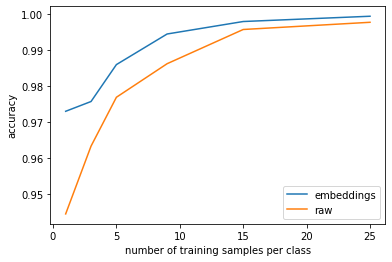

In [ ]:
#don't modify this
test_samples_per_class = 140
crossval_iterations = 100

num_labeled_samples = [1, 3, 5, 9, 15, 25]
embedding_scores = [compute_average_score(lab2lat, i, test_samples_per_class, crossval_iterations) for i in num_labeled_samples]
raw_scores = [compute_average_score(lab2im, i, test_samples_per_class, crossval_iterations) for i in num_labeled_samples]

print("Embedding scores:", embedding_scores)
print("Raw Scores:", raw_scores)

plt.plot(num_labeled_samples, embedding_scores, label='embeddings')
plt.plot(num_labeled_samples, raw_scores, label='raw')
plt.legend()
plt.xlabel('number of training samples per class')
plt.ylabel('accuracy')



A) What is the mean accuracy using cross-validation of KNN with Euclidean distance on the embeddings when only a single labeled example is available per class? Does this match your expectation?

B) What is the mean accuracy using cross-validation of KNN with Euclidean distance on the raw pixels when only a single labeled example is available per class? Does this match your expectation?

C) What is the mean accuracy using cross-validation of KNN with Euclidean distance on the embeddings for the following numbers of labeled examples per class: 3, 5, 9, 15, 25?

D) What is the mean accuracy using cross-validation of KNN with Euclidean distance on the raw pixels for the following numbers of labeled examples per class: 3, 5, 9, 15, 25?

E) What performs best on this dataset when only a few labeled examples are available: doing KNN on the embeddings or on the raw pixels?
